# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/file/d/1kNhM93RGWKUBIZ2lBv1dZUf1sD8X73yV/view?usp=sharing

As we are using the older version of the torchtext, please run the following to downgrade the torchtext version:

If you are interested to use the most recent version if torchtext, you can look at the following document to see how to convert the legacy version to the new version:
https://colab.research.google.com/github/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb

In [ ]:
!pip install torchtext==0.6

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import torch
import torchtext
print(torch.__version__)
print(torchtext.__version__)

2.1.0
0.6.0


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [ ]:
from torchtext.data import Field, TabularDataset

In [ ]:
torch.manual_seed(10)

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [ ]:
nospam = False
spam = False

for line in open("C:/Users/Admin/Downloads/SMSSpamCollection"):
    if (line[0] == 'h' and not nospam):
        print(line)
        nospam = True
    if (line[0] == 's' and not spam):
        print(line)
        spam = True
    if (nospam and spam):
        break


ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



The label value for a spam message is 'spam'  
The label value for a non-spam message is 'ham'

### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
spam = 0
ham = 0

for line in open("C:/Users/Admin/Downloads/SMSSpamCollection"):
    if (line[0] == 'h'):
        ham += 1
    elif (line[0] == 's'):
        spam += 1

print("Spam: ", spam)
print("Non-spam: ", ham)

Spam:  747
Non-spam:  4827


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

#### Advantage:
- There are less characters than words (combination of characters) in English. Therefore, we will need less storage to store the embeddings
- In messages, there may be mis-spellings. Therefore, a model built on characters will be trained on more information and will be less vulnerable to such events (can possibly recognize a mis-spelled word instead of ignoring the entire word like in word-trained models)

#### Disadvantage:
- RNN layer uses "history" to create a reresentation of the input to Linear layers. The history is used to relate words that may be far away from each other. On the other hand, using characters to train may make it more difficult to recognize such dependence, since the scope of using characters is too small.
- The model will probably take more time to train, as we are going into a higher level of details (more characters in a sentence compared to words in a sentence).

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file.

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file.
In our case, the dataset has two fields:

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [ ]:
import torchtext

text_field = torchtext.data.Field(sequential=True, tokenize=lambda x: x,
                           include_lengths=True, batch_first=True,
                           use_vocab=True)
label = torchtext.data.Field(sequential=False, preprocessing=lambda x: int(x == 'spam'),
                             use_vocab=False, batch_first=True,
                             is_target=True)

dataset = torchtext.data.TabularDataset("C:/Users/Admin/Downloads/SMSSpamCollection",
                                        "tsv",
                                        [('label', label), ('sms', text_field)])

train_set, valid_set, test_set = dataset.split(split_ratio=[0.6,0.2,0.2])

In [ ]:
dataset[0].label

0

In [ ]:
dataset[0].sms

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [ ]:
print(len(dataset))
print(len(train_set))
print(len(valid_set))
print(len(test_set))

5572
3343
1115
1114


### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [ ]:
# save the original training examples
old_train_examples = train_set.examples
# get all the spam messages in `train`
train_spam = []
for item in train_set.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train_set.examples = old_train_examples + train_spam * 6

In [ ]:
spamCount = 0
okCount = 0
for item in train_set.examples:
    if item.label == 1:
        spamCount += 1
    else:
        okCount += 1

print(spamCount, okCount)

3185 2888


### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [ ]:
text_field.build_vocab(train_set)
text_field.vocab.stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x0000013CCDF7DE50>>,
            {'<unk>': 0,
             '<pad>': 1,
             ' ': 2,
             'e': 3,
             'o': 4,
             't': 5,
             'a': 6,
             'n': 7,
             'r': 8,
             'i': 9,
             's': 10,
             'l': 11,
             'u': 12,
             'h': 13,
             'd': 14,
             '0': 15,
             'c': 16,
             '.': 17,
             'm': 18,
             'y': 19,
             'w': 20,
             'p': 21,
             'g': 22,
             '1': 23,
             'f': 24,
             'b': 25,
             '2': 26,
             '8': 27,
             'T': 28,
             'k': 29,
             'E': 30,
             'v': 31,
             'S': 32,
             '5': 33,
             '4': 34,
             'C': 35,
             'O': 36,
             'I': 37,
             'N': 38,
             '6': 39,
             

In [ ]:
text_field.vocab.itos

['<unk>',
 '<pad>',
 ' ',
 'e',
 'o',
 't',
 'a',
 'n',
 'r',
 'i',
 's',
 'l',
 'u',
 'h',
 'd',
 '0',
 'c',
 '.',
 'm',
 'y',
 'w',
 'p',
 'g',
 '1',
 'f',
 'b',
 '2',
 '8',
 'T',
 'k',
 'E',
 'v',
 'S',
 '5',
 '4',
 'C',
 'O',
 'I',
 'N',
 '6',
 'x',
 'A',
 '7',
 '3',
 'R',
 '!',
 '9',
 ',',
 'P',
 'M',
 'W',
 'U',
 'L',
 'H',
 'D',
 'G',
 'F',
 'B',
 'Y',
 '/',
 '?',
 "'",
 '£',
 '-',
 '&',
 ':',
 'X',
 'V',
 'z',
 'j',
 'K',
 'J',
 ')',
 '*',
 ';',
 '+',
 '(',
 'q',
 'Q',
 '"',
 '#',
 '=',
 '@',
 'ü',
 'Z',
 '>',
 '$',
 'Ü',
 '[',
 ']',
 '\x92',
 '<',
 '_',
 '‘',
 '%',
 '\x93',
 '|',
 '…',
 'ú',
 '–',
 '’',
 '“',
 'é',
 '\\',
 '\x94',
 '^',
 '~',
 '\x91',
 'É',
 'ì']

`text_field.vocab.stoi` maps each character in ever existed in training set to integer (unique)   
`text_field.vocab.itos` is a list of these characters, ordered by their integer identifier (equal to index to this list)

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

`<unk>` means unknown character that is not recognized by build_vocab  
`<pad>` means the padding that is added to each sms so they have same length

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
train_iter = torchtext.data.BucketIterator(train_set,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
valid_iter = torchtext.data.BucketIterator(valid_set,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)
test_iter = torchtext.data.BucketIterator(test_set,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

In [ ]:
pad = [0] * 10
max_length = [0] * 10

for i, batch in enumerate(train_iter):
    if (i >= 10):
        break

    all_sms = batch.sms[0]
    max_length[i] = max(len(sms) for sms in all_sms)
    pad[i] = sum([sms.eq(text_field.vocab.stoi["<pad>"]).sum().item() for sms in all_sms])

print(pad)
print(max_length)

[0, 63, 33, 13, 0, 16, 0, 5, 49, 33]
[152, 129, 47, 130, 156, 39, 146, 132, 99, 44]


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing.
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(RNN, self).__init__()
        self.ident = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2) # only 2 class - spam or not spam

    # x = batch
    def forward(self, x):
        input_onehot = torch.stack([self.ident[sms] for sms in x])
        out, _ = self.rnn(input_onehot)
        out = torch.max(out, dim=1)[0]
        out = self.fc(out)
        return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [ ]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    correct, total = 0, 0
    for sms, labels in data:
        pred = model(sms[0]).max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest.

In [ ]:
import matplotlib.pyplot as plt

def train(model, train, valid, num_epochs=5, learning_rate=0.0001):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    train_acc = np.zeros(num_epochs)
    valid_acc = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        avg_loss = 0
        for sms, labels in train:
            optimizer.zero_grad()
            pred = model(sms[0])
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()

        train_acc[epoch] = get_accuracy(model, train)
        valid_acc[epoch] = get_accuracy(model, valid)
        print(("Epoch {}: Train accuracy: {}, Validation accuracy: {} ").format(
               epoch + 1,
               train_acc[epoch],
               valid_acc[epoch]))

    # plot
    plt.title("Training vs Validation Accuracy")
    n = len(train_acc) # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Epoch 1: Train accuracy: 0.9310060925407542, Validation accuracy: 0.9452914798206278 
Epoch 2: Train accuracy: 0.9247488885229705, Validation accuracy: 0.9004484304932735 
Epoch 3: Train accuracy: 0.9069652560513749, Validation accuracy: 0.9596412556053812 
Epoch 4: Train accuracy: 0.9008727152972172, Validation accuracy: 0.9614349775784753 
Epoch 5: Train accuracy: 0.9104231845875185, Validation accuracy: 0.9650224215246637 


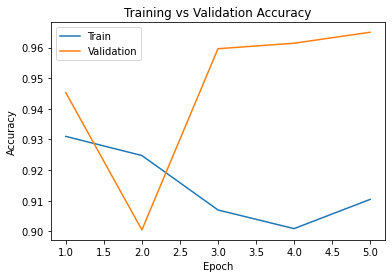

In [ ]:
model = RNN(len(text_field.vocab.itos), len(text_field.vocab.itos), n_layers=1)
train(model, train_iter, valid_iter, num_epochs=5, learning_rate=0.0001)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

- 1. We observe that the validation accuracy is already very high (0.96). However, the results flutuates by too much, inferring that we should run the training for a longer period of time so that the results (accuracy) are more stable. **Epoch = 15**
    - Training accuracy: 0.936604643504034
    - Validation accuracy: 0.9757847533632287
    
- 2. The accuracy slightly increased (last time was already pretty high), but results are definitely more stable, and it is shown that the accuracy reached stable state. We can try and confirm that the model is behaving differently given that the learning rate is higher **Epoch = 15, LR = 0.01**
    - Training accuracy: 1.0
    - Validation accuracy: 0.9874439461883409
    
- 3. Even though the accuracy reached peak, there was some significant fluctuations that is caused by too high learning rate. We will return to original learning rate. Now try to adjust the number of each RNN layer (previously 1), trying out with a 2-layer stacked RNN **Num_layers = 2**
    - Training accuracy: 0.9767824798287502
    - Validation accuracy: 0.9775784753363229
    
- 4. The results seems stable, with high accuracy, and very much usable. Final change I want to try is to implement the recommended concatenating the max-pooling and average-pooling of the RNN outputs: **RNN_new**
    - Training accuracy: 0.9738185410834843
    - Validation accuracy: 0.9695067264573991
    
I choose model 3 because it is the most stable, with very high accuracy.

Epoch 1: Train accuracy: 0.527251770130084, Validation accuracy: 0.1452914798206278 
Epoch 2: Train accuracy: 0.9359459904495308, Validation accuracy: 0.95695067264574 
Epoch 3: Train accuracy: 0.9450024699489544, Validation accuracy: 0.9668161434977578 
Epoch 4: Train accuracy: 0.9496130413304792, Validation accuracy: 0.9614349775784753 
Epoch 5: Train accuracy: 0.9565288984027663, Validation accuracy: 0.967713004484305 
Epoch 6: Train accuracy: 0.9616334595751688, Validation accuracy: 0.9515695067264573 
Epoch 7: Train accuracy: 0.964103408529557, Validation accuracy: 0.9632286995515695 
Epoch 8: Train accuracy: 0.9662440309566935, Validation accuracy: 0.968609865470852 
Epoch 9: Train accuracy: 0.9509303474394862, Validation accuracy: 0.97847533632287 
Epoch 10: Train accuracy: 0.9660793676930677, Validation accuracy: 0.9461883408071748 
Epoch 11: Train accuracy: 0.9573522147208958, Validation accuracy: 0.97847533632287 
Epoch 12: Train accuracy: 0.948295735221472, Validation accura

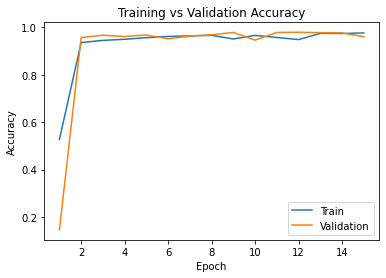

In [ ]:
model_final = RNN(len(text_field.vocab.itos), len(text_field.vocab.itos), n_layers=2)
train(model_final, train_iter, valid_iter, num_epochs=15, learning_rate=0.0001)

Epoch 1: Train accuracy: 0.5249464844393216, Validation accuracy: 0.14349775784753363 
Epoch 2: Train accuracy: 0.9428618475218179, Validation accuracy: 0.95695067264574 
Epoch 3: Train accuracy: 0.9601514902025358, Validation accuracy: 0.9632286995515695 
Epoch 4: Train accuracy: 0.9624567758932983, Validation accuracy: 0.957847533632287 
Epoch 5: Train accuracy: 0.9659147044294418, Validation accuracy: 0.9632286995515695 
Epoch 6: Train accuracy: 0.9700312860200889, Validation accuracy: 0.9730941704035875 
Epoch 7: Train accuracy: 0.9285361435863659, Validation accuracy: 0.8780269058295964 
Epoch 8: Train accuracy: 0.9718425819199736, Validation accuracy: 0.9748878923766816 
Epoch 9: Train accuracy: 0.9710192656018443, Validation accuracy: 0.9721973094170404 
Epoch 10: Train accuracy: 0.9631154289478018, Validation accuracy: 0.97847533632287 
Epoch 11: Train accuracy: 0.964103408529557, Validation accuracy: 0.97847533632287 
Epoch 12: Train accuracy: 0.9726658982381031, Validation ac

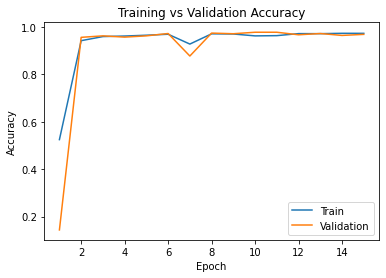

In [ ]:
class RNN_new(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(RNN_new, self).__init__()
        self.ident = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size*2, 2) # only 2 class - spam or not spam

    # x = batch
    def forward(self, x):
        input_onehot = torch.stack([self.ident[sms] for sms in x])
        out, _ = self.rnn(input_onehot)
        out = torch.cat([torch.max(out, dim=1)[0],
                         torch.mean(out, dim=1)], dim=1)
        out = self.fc(out)
        return out

model = RNN_new(len(text_field.vocab.itos), len(text_field.vocab.itos), n_layers=2)
train(model, train_iter, valid_iter, num_epochs=15, learning_rate=0.0001)

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in valid_set.examples if e.label == 1],
    valid_set.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in valid_set.examples if e.label == 0],
    valid_set.fields)

valid_spam_iter = torchtext.data.BucketIterator(valid_spam,
                                               batch_size=32,
                                               sort_key=lambda x: len(x.sms),
                                               sort_within_batch=True,
                                               repeat=False)
valid_nospam_iter = torchtext.data.BucketIterator(valid_nospam,
                                               batch_size=32,
                                               sort_key=lambda x: len(x.sms),
                                               sort_within_batch=True,
                                               repeat=False)

In [ ]:
false_positive = 1 - get_accuracy(model_final, valid_nospam_iter)
false_negative = 1 - get_accuracy(model_final, valid_spam_iter)
print(false_positive)
print(false_negative)

0.03858185610010423
0.019230769230769273


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

In [ ]:
- False negative in this case would block spam messages on the user's phone (ok)
- Flase positive in this case would block valid messages on the user's phone (dangerous!)

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [ ]:
get_accuracy(model_final, test_iter)

0.973967684021544

### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
test_spam = torchtext.data.Dataset(
    [e for e in test_set.examples if e.label == 1],
    test_set.fields)
test_nospam = torchtext.data.Dataset(
    [e for e in test_set.examples if e.label == 0],
    test_set.fields)

test_spam_iter = torchtext.data.BucketIterator(test_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

test_nospam_iter = torchtext.data.BucketIterator(test_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

false_positive = 1 - get_accuracy(model_final, test_nospam_iter)
false_negative = 1 - get_accuracy(model_final, test_spam_iter)
print(false_positive)
print(false_negative)

0.026584867075664653
0.044117647058823484


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [ ]:
msg = "machine learning is sooo cool!"
x = torch.stack([torch.tensor(text_field.vocab.stoi[char]) for char in msg]).unsqueeze_(0)

result = F.softmax(model_final(x), dim=1)[0][1].item()
print(result)

0.10677974671125412

### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

I think that spam detection is more easier than other more sophisticated DL tasks, such as generating texts, predicting the stock market. There has been various models for spam detection, such as Multilayer Perceptron Neural Networks (MLPNNs) or Radial Base Function Neural Networks (RBFNN).

For a baseline model, we can use a simple heuristic engine. We can pre-determine a set of "suspicious" words, such as "deal", "sale", "free", "sign up", and then determine how many times such words occur in our message, rate them by points, and determine a threshold for deciding whether a message is spam or not.